# Rotten Tomatoes movies and critic reviews
## 영화 리뷰의 자주 나온 키워드를 통해서 평점을 예측

* 가설 : 평점이 좋은 영화엔 특정 키워드가 자주 나올 것이고 그것을 토대로 평점이 예측 가능할 것이다


In [1]:
import pandas as pd
df1 = pd.read_csv("/content/rotten_tomatoes_movies.csv", encoding = 'unicode_escape')
df2 = pd.read_csv("/content/rotten_tomatoes_critic_reviews.csv", encoding = 'unicode_escape')

In [2]:
print(df1.shape)
df1.head()

(17712, 22)


,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,runtime,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2015-11-25,119.0,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2012-09-04,90.0,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,2014-07-24,122.0,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2017-01-13,95.0,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2016-06-10,127.0,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [3]:
print(df2.shape)
df2

(132549, 9)


,Unnamed: 0,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
...,...,...,...,...,...,...,...,...,...
132544,132544,m/an_education,Sara Michelle Fetters,False,MovieFreak.com,Fresh,4/4,2009-10-16,"I laughed and I cried, and while saying those ..."
132545,132545,m/an_education,Mick LaSalle,True,San Francisco Chronicle,Fresh,4/4,2009-10-16,Hornby's humane and humorous screenplay is tru...
132546,132546,m/an_education,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2009-10-17,"Sheer joy of an intelligent, grown up film"
132547,132547,m/an_education,Louise Keller,False,Urban Cinefile,Fresh,NaN,2009-10-17,An irresistible tale of seduction in which inn...


In [4]:
df = pd.merge(df1, df2, how='left')
print(df.shape)
df.head()

(147541, 30)


,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,runtime,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,Unnamed: 0,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2015-11-25,119.0,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76,0.0,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2015-11-25,119.0,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76,1.0,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2015-11-25,119.0,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76,2.0,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2015-11-25,119.0,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76,3.0,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2015-11-25,119.0,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76,4.0,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [5]:
# 전처리

# 개봉일 기준 2000년대 영화로 필터링
df = df[df['original_release_date'] >= '2000-01-01']
# 필요없는 feature 제거
df = df.drop(['critics_consensus', 'genres', 'actors', 'movie_info', 'content_rating', 'directors', 'authors', 'streaming_release_date', 'runtime', 'production_company', 'critic_name', 'top_critic', 'publisher_name', 'review_date'], axis = 1)

In [6]:
df = df.drop('Unnamed: 0', axis=1)

In [7]:
pd.DataFrame(df.isnull( ).sum(), columns=['결측치 수'])

,결측치 수
rotten_tomatoes_link,0
movie_title,0
original_release_date,0
tomatometer_status,40
tomatometer_rating,40
tomatometer_count,40
audience_status,2030
audience_rating,271
audience_count,272
tomatometer_top_critics_count,0


In [8]:
df.dropna(inplace=True)

In [9]:
df.reset_index(inplace=True)

In [10]:
df.drop(['index'], axis=1, inplace=True)

In [11]:
df

,rotten_tomatoes_link,movie_title,original_release_date,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,review_type,review_score,review_content
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76,Fresh,3.5/5,Whether audiences will get behind The Lightnin...
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76,Rotten,1/4,Harry Potter knockoffs don't come more transpa...
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76,Fresh,3.5/5,"Percy Jackson isn't a great movie, but it's a ..."
3,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76,Fresh,B,"Fun, brisk and imaginative"
4,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76,Fresh,3/5,"Crammed with dragons, set-destroying fights an..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68044,m/an_education,An Education,2009-10-09,Certified-Fresh,94.0,195.0,Upright,80.0,54962.0,46,183,12,Fresh,10/10,"Sensitively directed by Lone Sherfig, with ter..."
68045,m/an_education,An Education,2009-10-09,Certified-Fresh,94.0,195.0,Upright,80.0,54962.0,46,183,12,Fresh,3/4,"A star may or may not be born in An Education,..."
68046,m/an_education,An Education,2009-10-09,Certified-Fresh,94.0,195.0,Upright,80.0,54962.0,46,183,12,Fresh,4/4,"I laughed and I cried, and while saying those ..."
68047,m/an_education,An Education,2009-10-09,Certified-Fresh,94.0,195.0,Upright,80.0,54962.0,46,183,12,Fresh,4/4,Hornby's humane and humorous screenplay is tru...


In [12]:
# 리뷰 점수 전처리

def score(x):
  if '/' in str(x):
    return int(float(str(x).split('/')[0]) / float(str(x).split('/')[-1]) * 10)
  elif x == "A" or x == 'a' or x =='A+' or x =='A-':
    return 10
  elif x == 'B' or x == 'b' or x == 'B+' or x == 'B-':
    return 8
  elif x == 'C' or x == 'c' or x == 'C+' or x == 'C-':
    return 6
  elif x == 'D' or x == 'd' or x == 'D+' or x == 'D+':
    return 4
  elif x == 'F' or x == 'f':
    return 2
  else:
    return 0

df['review_score'] = df['review_score'].apply(score)
# 리뷰 점수가 10이 넘는 값들 제거
df.drop(df[df['review_score'] > 10].index, axis='index', inplace=True)

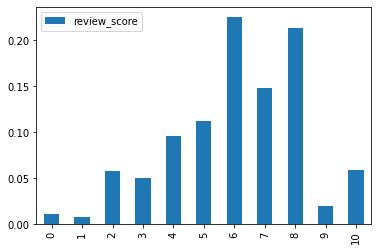

In [13]:
pd.DataFrame(df['review_score'].value_counts(normalize=True)).sort_index().plot(kind='bar')

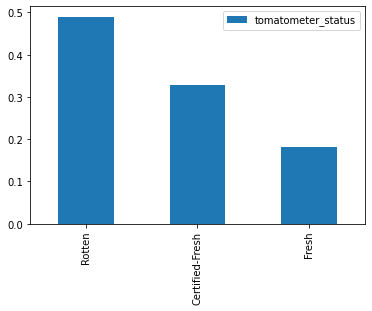

In [14]:
pd.DataFrame(df['tomatometer_status'].value_counts(normalize=True)).plot(kind='bar')

In [15]:
# 토마토미터 전처리
def tomato(x):
  if x == 'Certified-Fresh':
    return 2
  elif x == 'Fresh':
    return 1
  else:
    return 0

df['tomatometer_status'] = df['tomatometer_status'].apply(tomato)

In [16]:
# 리뷰 내용을 토큰화
import re

def tokenize(text):
    tokens = re.sub(r"[^a-zA-Z0-9 ]", "", text)

    tokens = tokens.lower().split()
    
    return tokens

In [17]:
df['token'] = df['review_content'].apply(tokenize)

In [18]:
# 불용어를 제거

import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")
STOP_WORDS = nlp.Defaults.stop_words.union(['the', 'a', 'and', 'of', 'to', 'is', 'in', 'its', 'it', 'that', "it's", "there's", "that's"])
tokenizer = Tokenizer(nlp.vocab)

tokens = []

for doc in tokenizer.pipe(df['review_content']):
    doc_tokens = []

    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False) & (token.text.lower() not in STOP_WORDS):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['token'] = tokens

In [19]:
from collections import Counter

def word_count(docs):
    
    word_counts = Counter()

    word_in_docs = Counter()

    total_docs = len(docs)

    word_counts.update(docs)
    word_in_docs.update(set(docs))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    return list(wc.sort_values(by='rank')['word'][:5])

In [20]:
df['word'] = df['token'].apply(word_count)

In [21]:
df.head(3)

,rotten_tomatoes_link,movie_title,original_release_date,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,review_type,review_score,review_content,token,word
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,0,49.0,149.0,Spilled,53.0,254421.0,43,73,76,Fresh,7,Whether audiences will get behind The Lightnin...,"[audiences, lightning, thief, hard, predict., ...","[audiences, lightning, thief, hard, predict.]"
1,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,0,49.0,149.0,Spilled,53.0,254421.0,43,73,76,Rotten,2,Harry Potter knockoffs don't come more transpa...,"[harry, potter, knockoffs, don't, come, transp...","[harry, potter, knockoffs, don't, come]"
2,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010-02-12,0,49.0,149.0,Spilled,53.0,254421.0,43,73,76,Fresh,7,"Percy Jackson isn't a great movie, but it's a ...","[percy, jackson, isn't, great, movie,, good, o...","[percy, jackson, isn't, great, movie,]"


# 리뷰 점수 예측

In [22]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.callbacks import EarlyStopping
y = df['review_score']
X = df['word']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

max_words = 1000
max_len = 100

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
X_train_encoded = tok.texts_to_sequences(X_train)
X_train_pad = sequence.pad_sequences(X_train_encoded,maxlen=max_len)

tok.fit_on_texts(X_test)
X_test_encoded = tok.texts_to_sequences(X_test)
X_test_pad = sequence.pad_sequences(X_test_encoded,maxlen=max_len)

In [23]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(128,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(11,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [24]:
model = RNN()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [25]:
model.fit(X_train_pad,y_train,batch_size=128,epochs=10,
          validation_data=(X_test_pad,y_test), callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=3)])

Epoch 1/10
373/373 [==============================] - 40s 101ms/step - loss: 2.0806 - accuracy: 0.2203 - val_loss: 2.0913 - val_accuracy: 0.2225
Epoch 2/10
373/373 [==============================] - 37s 100ms/step - loss: 2.0041 - accuracy: 0.2551 - val_loss: 2.1430 - val_accuracy: 0.2191
Epoch 3/10
373/373 [==============================] - 37s 100ms/step - loss: 1.9712 - accuracy: 0.2668 - val_loss: 2.1742 - val_accuracy: 0.2161
Epoch 4/10
373/373 [==============================] - 37s 100ms/step - loss: 1.9586 - accuracy: 0.2708 - val_loss: 2.1657 - val_accuracy: 0.2119


In [26]:
df['review_score'].value_counts(normalize=True).sort_index()

0     0.011536
1     0.008230
2     0.058092
3     0.050215
4     0.095801
5     0.112114
6     0.224933
7     0.147707
8     0.213308
9     0.019545
10    0.058518
Name: review_score, dtype: float64

In [27]:
model.evaluate(X_test_pad, y_test)

638/638 [==============================] - 9s 14ms/step - loss: 2.1657 - accuracy: 0.2119


[2.165741443634033, 0.21185402572155]

# 토마토미터 예측


In [28]:
y = df['tomatometer_status']
X = df['word']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

max_words = 10000
max_len = 500

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
X_train_encoded = tok.texts_to_sequences(X_train)
X_train_pad = sequence.pad_sequences(X_train_encoded,maxlen=max_len)

tok.fit_on_texts(X_test)
X_test_encoded = tok.texts_to_sequences(X_test)
X_test_pad = sequence.pad_sequences(X_test_encoded,maxlen=max_len)

In [29]:
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential

vocab_size = len(tok.word_index) + 1
embedding_matrix = np.zeros((vocab_size,500))

model = Sequential()
model.add(Embedding(vocab_size, 500, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(GlobalAveragePooling1D()) 
model.add(Dense(3, activation='softmax'))

In [30]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
model.fit(X_train_pad, y_train, batch_size=64, epochs=5, validation_split=0.2)

Epoch 1/5
596/596 [==============================] - 13s 22ms/step - loss: 1.0509 - accuracy: 0.4900 - val_loss: 1.0285 - val_accuracy: 0.4863
Epoch 2/5
596/596 [==============================] - 13s 21ms/step - loss: 1.0264 - accuracy: 0.4900 - val_loss: 1.0242 - val_accuracy: 0.4863
Epoch 3/5
596/596 [==============================] - 13s 21ms/step - loss: 1.0252 - accuracy: 0.4900 - val_loss: 1.0239 - val_accuracy: 0.4863
Epoch 4/5
596/596 [==============================] - 13s 21ms/step - loss: 1.0252 - accuracy: 0.4900 - val_loss: 1.0238 - val_accuracy: 0.4863
Epoch 5/5
596/596 [==============================] - 13s 21ms/step - loss: 1.0252 - accuracy: 0.4900 - val_loss: 1.0240 - val_accuracy: 0.4863


In [32]:
df['tomatometer_status'].value_counts(normalize=True).sort_index()

0    0.489794
1    0.181419
2    0.328787
Name: tomatometer_status, dtype: float64

In [33]:
model.evaluate(X_test_pad, y_test)

638/638 [==============================] - 7s 10ms/step - loss: 1.0253 - accuracy: 0.4911


[1.0252619981765747, 0.4911094903945923]